# A Small Experiment of PU Learning

This is to understanding how PU learning works in Multi-Class Outlier Detection cases


### Setup

In [128]:
# This helps when you're loading functions  defined in an external script (if the script is updated while the notebook is running)
%load_ext autoreload 
%autoreload 2

import numpy as np
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.decomposition import PCA
from math import sqrt
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from sklearn.utils import resample
from scipy.stats import norm
import copy

import sys
sys.path.append("..")

from mypackage.data_models import generate_data_uniform_plus_normal
from mypackage.PUL import compute_pu_scores, compute_mean_distance, em_adjust_proportions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

In [129]:
# Generate data
K = 2
dim = 50
means = [-1, 1]
radius = 4
a_signal = 4

# Training, Calibration, and Test data
num_n_in_train = 2000
n_in_cal = [1000, 1000]
n_in_test = [1600, 200]
n_out_test = 200

# Range of rho values
rho_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

# Monte Carlo iterations
num_iterations = 10

# EM iterations
num_em_iterations = 10

## Preparation

In [130]:
# Define machine learning models
binary_classifier = SVC(C=1, probability=True)
oneclass_classifier = OneClassSVM(gamma='auto')

# Store results
mean_distances = {
    'multi_step': [],
    'compute_pu_scores_multi_step_twotest': [],
    'multi_step_em': [],
    'compute_pu_scores_multi_step_twotest_em': []
}

ci_distances = {
    'multi_step': [],
    'compute_pu_scores_multi_step_twotest': [],
    'multi_step_em': [],
    'compute_pu_scores_multi_step_twotest_em': []
}

### Two PU Learning Methods(Multi_step, Multi_step_two_parts)

In [131]:
for rho in rho_values:
    distances_multi_step = []
    distances_twotest = []
    distances_multi_step_em = []
    distances_twotest_em = []

    for _ in range(num_iterations):
        # Initial proportions
        pi_k = np.array([0.5, 0.5])  # Initial guess for the proportions of inliers

        # Generate initial training, calibration, and test data
        n_in_train = [int(rho * num_n_in_train), int((1 - rho) * num_n_in_train)]
        X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train, 0, dim, means, radius, a_signal)
        X_cal, Y_cal = generate_data_uniform_plus_normal(K, n_in_cal, 0, dim, means, radius, a_signal)
        X_test, Y_test = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)
        X_test_part2, Y_test_part2 = generate_data_uniform_plus_normal(K, n_in_test, n_out_test, dim, means, radius, a_signal)

        # Compute PU scores
        scores_cal_multi_step, scores_test_multi_step, _ = compute_pu_scores(
            K, X_train, Y_train, X_cal, Y_cal, X_test, binary_classifier,
            oneclass_classifier=oneclass_classifier, multi_step=True)
        scores_cal_twotest, scores_test_twotest, _ = compute_pu_scores(
            K, X_train, Y_train, X_cal, Y_cal, X_test, binary_classifier,
            oneclass_classifier=oneclass_classifier, multi_step=True, X_test_part2=X_test_part2)

        # Compute mean distances
        distances_multi_step.append(compute_mean_distance(K, scores_test_multi_step, Y_test))
        distances_twotest.append(compute_mean_distance(K, scores_test_twotest, Y_test_part2))

        # EM Algorithm to adjust the proportion in training data
        n_in_train = em_adjust_proportions(K, X_test, num_n_in_train, num_em_iterations)
        X_train, Y_train = generate_data_uniform_plus_normal(K, n_in_train, 0, dim, means, radius, a_signal)

        # Compute PU scores
        scores_cal_multi_step_em, scores_test_multi_step_em, _ = compute_pu_scores(
            K, X_train, Y_train, X_cal, Y_cal, X_test, binary_classifier,
            oneclass_classifier=oneclass_classifier, multi_step=True)
        scores_cal_twotest_em, scores_test_twotest_em, _ = compute_pu_scores(
            K, X_train, Y_train, X_cal, Y_cal, X_test, binary_classifier,
            oneclass_classifier=oneclass_classifier, multi_step=True, X_test_part2=X_test_part2)

        # Compute mean distances
        distances_multi_step_em.append(compute_mean_distance(K, scores_test_multi_step_em, Y_test))
        distances_twotest_em.append(compute_mean_distance(K, scores_test_twotest_em, Y_test_part2))

    # Calculate mean distances and confidence intervals
    mean_distances['multi_step'].append(np.mean(distances_multi_step))
    mean_distances['compute_pu_scores_multi_step_twotest'].append(np.mean(distances_twotest))
    mean_distances['multi_step_em'].append(np.mean(distances_multi_step_em))
    mean_distances['compute_pu_scores_multi_step_twotest_em'].append(np.mean(distances_twotest_em))

    ci_distances['multi_step'].append((np.percentile(distances_multi_step, 5), np.percentile(distances_multi_step, 95)))
    ci_distances['compute_pu_scores_multi_step_twotest'].append((np.percentile(distances_twotest, 5), np.percentile(distances_twotest, 95)))
    ci_distances['multi_step_em'].append((np.percentile(distances_multi_step_em, 5), np.percentile(distances_multi_step_em, 95)))
    ci_distances['compute_pu_scores_multi_step_twotest_em'].append((np.percentile(distances_twotest_em, 5), np.percentile(distances_twotest_em, 95)))

### Plot

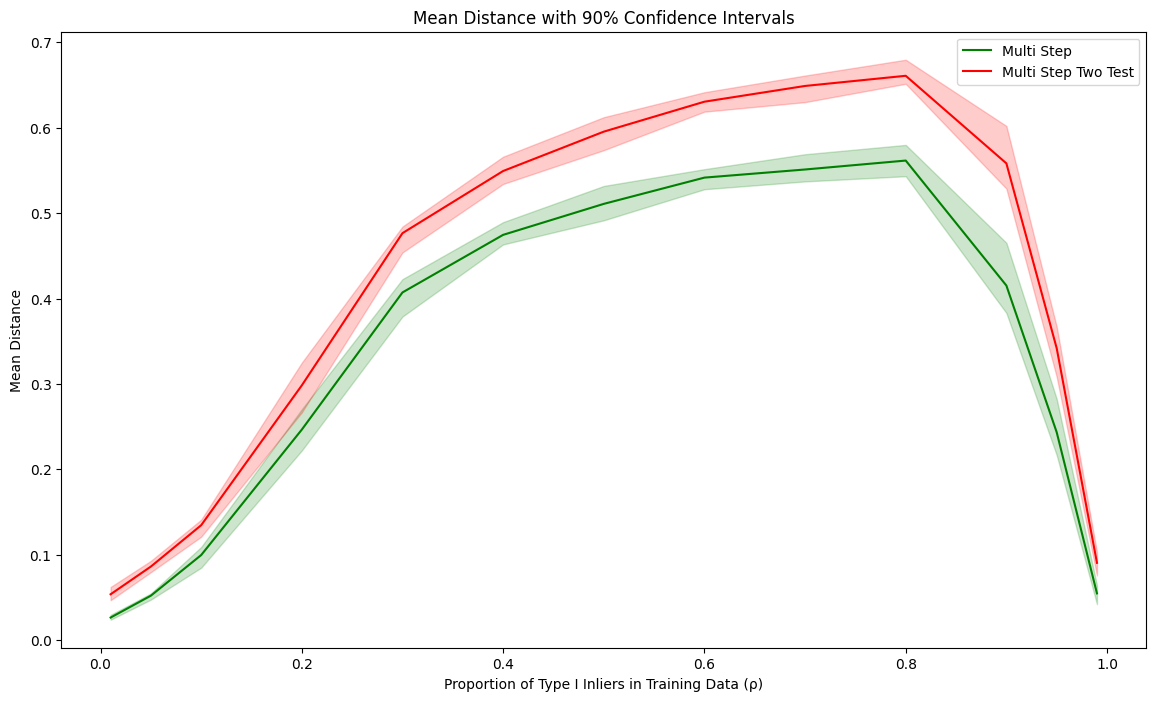

In [137]:
# Plotting
plt.figure(figsize=(14, 8))

plt.plot(rho_values, mean_distances['multi_step'], label='Multi Step', color='g')
plt.fill_between(rho_values, [ci[0] for ci in ci_distances['multi_step']], [ci[1] for ci in ci_distances['multi_step']], color='g', alpha=0.2)

plt.plot(rho_values, mean_distances['compute_pu_scores_multi_step_twotest'], label='Multi Step Two Test', color='r')
plt.fill_between(rho_values, [ci[0] for ci in ci_distances['compute_pu_scores_multi_step_twotest']], [ci[1] for ci in ci_distances['compute_pu_scores_multi_step_twotest']], color='r', alpha=0.2)

plt.xlabel('Proportion of Type I Inliers in Training Data (ρ)')
plt.ylabel('Mean Distance')
plt.title('Mean Distance with 90% Confidence Intervals')
plt.legend()
plt.show()

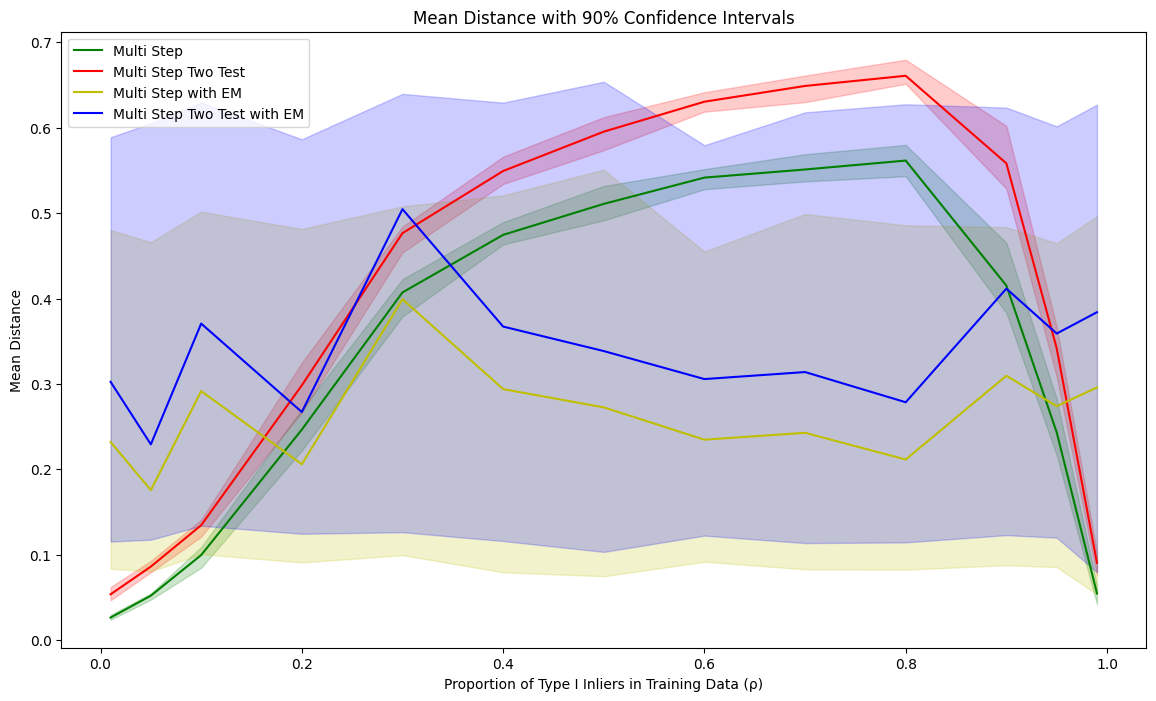

In [138]:
# Plotting
plt.figure(figsize=(14, 8))

plt.plot(rho_values, mean_distances['multi_step'], label='Multi Step', color='g')
plt.fill_between(rho_values, [ci[0] for ci in ci_distances['multi_step']], [ci[1] for ci in ci_distances['multi_step']], color='g', alpha=0.2)

plt.plot(rho_values, mean_distances['compute_pu_scores_multi_step_twotest'], label='Multi Step Two Test', color='r')
plt.fill_between(rho_values, [ci[0] for ci in ci_distances['compute_pu_scores_multi_step_twotest']], [ci[1] for ci in ci_distances['compute_pu_scores_multi_step_twotest']], color='r', alpha=0.2)

plt.plot(rho_values, mean_distances['multi_step_em'], label='Multi Step with EM', color='y')
plt.fill_between(rho_values, [ci[0] for ci in ci_distances['multi_step_em']], [ci[1] for ci in ci_distances['multi_step_em']], color='y', alpha=0.2)

plt.plot(rho_values, mean_distances['compute_pu_scores_multi_step_twotest_em'], label='Multi Step Two Test with EM', color='b')
plt.fill_between(rho_values, [ci[0] for ci in ci_distances['compute_pu_scores_multi_step_twotest_em']], [ci[1] for ci in ci_distances['compute_pu_scores_multi_step_twotest_em']], color='b', alpha=0.2)

plt.xlabel('Proportion of Type I Inliers in Training Data (ρ)')
plt.ylabel('Mean Distance')
plt.title('Mean Distance with 90% Confidence Intervals')
plt.legend()
plt.show()

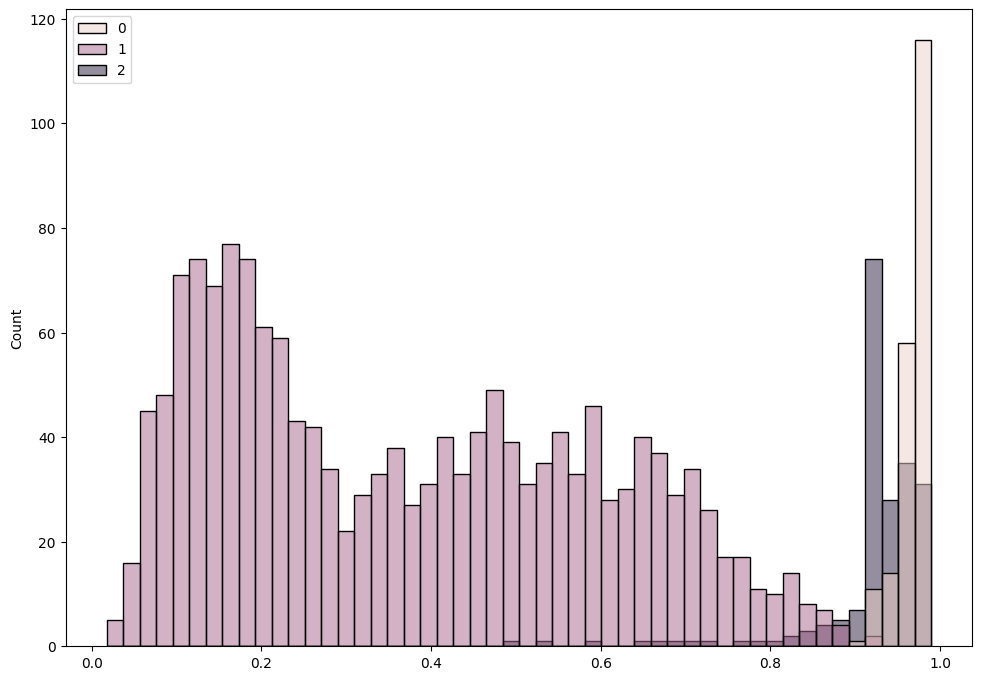

In [133]:
# Plot the conformity scores
rcParams['figure.figsize'] = 11.7,8.27
sns.histplot(x=scores_test_multi_step, hue=Y_test, bins=50)
plt.show()

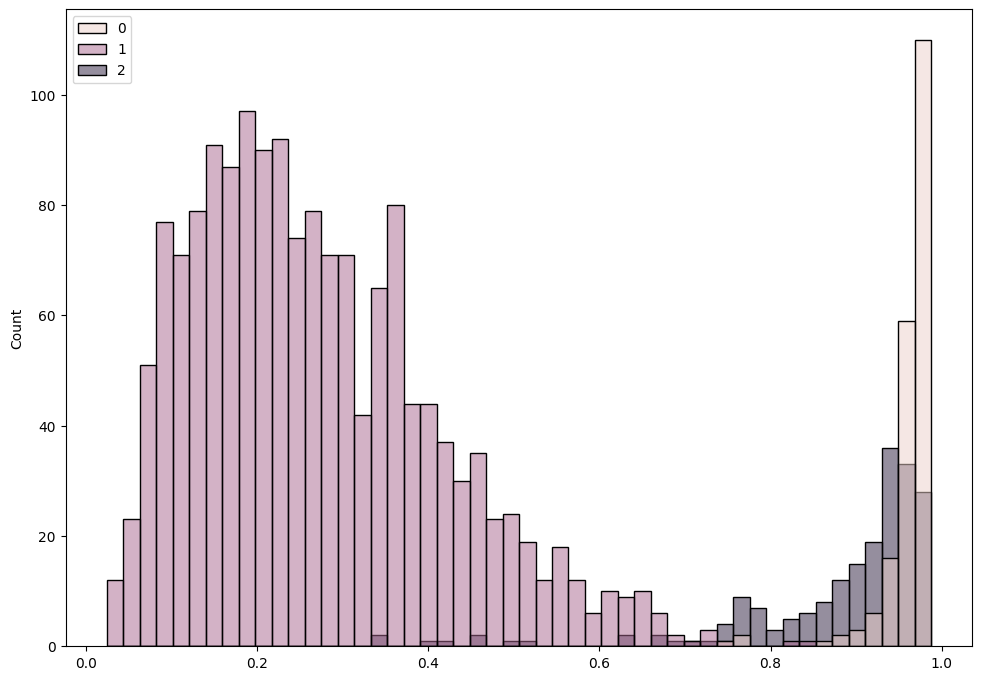

In [139]:
sns.histplot(x=scores_test_twotest, hue=Y_test_part2, bins=50)
plt.show()

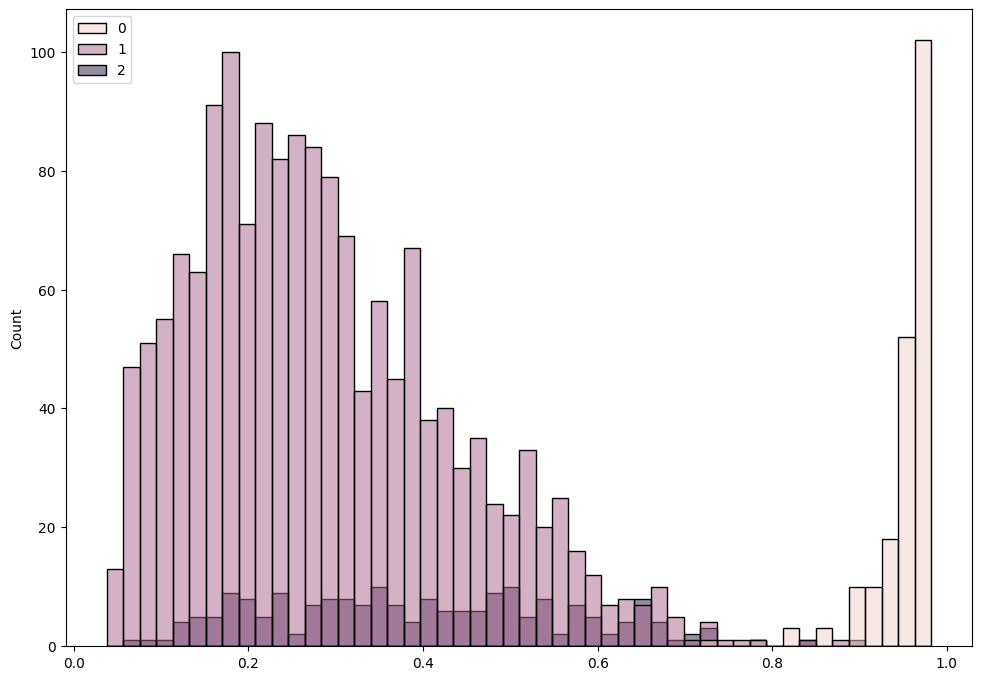

In [140]:
sns.histplot(x=scores_test_twotest_em, hue=Y_test_part2, bins=50)
plt.show()

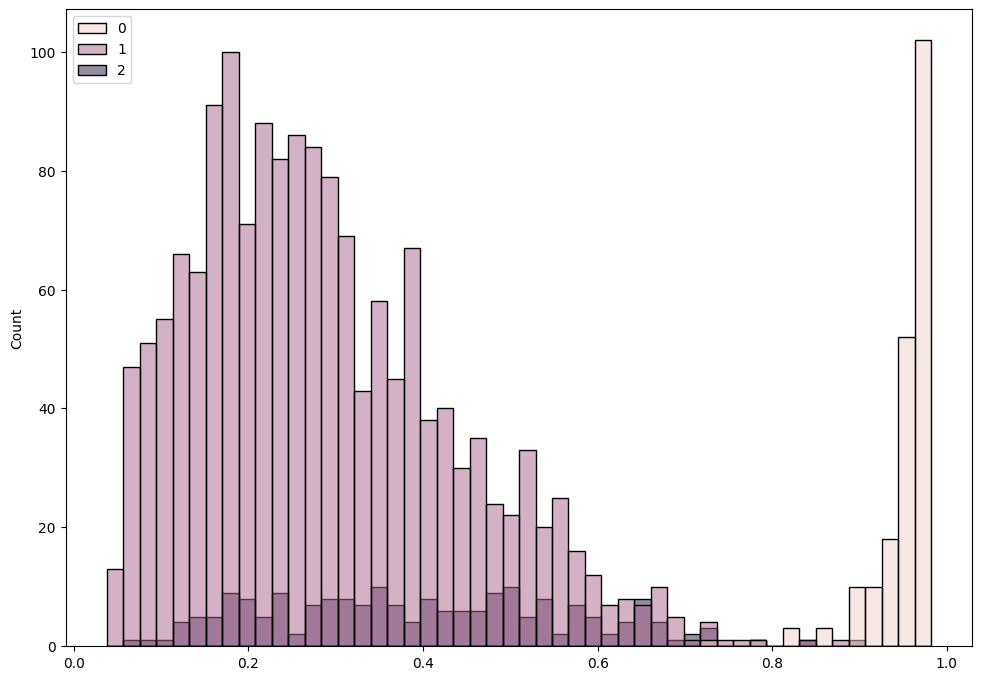

In [136]:
sns.histplot(x=scores_test_twotest_em, hue=Y_test_part2, bins=50)
plt.show()